In [ ]:
#import pyximport;pyximport.install()
#import functions2.pyx as hv

In [1]:
from functions import *
import re
import networkx as nx
from dask.distributed import Client
from nltk.util import ngrams
from dask import delayed
from dask import bag as db
from dask import compute
from nltk.util import ngrams
from sklearn.feature_extraction.text import HashingVectorizer , TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
import dask_ml.feature_extraction.text as dask_text
import dask
from itertools import chain
from dask import bag as db
from dask import dataframe as dd
from itertools import chain
import pandas as pd
import dask.array as da
import itertools
from dask.distributed import get_client
from umap import UMAP
import hdbscan
import time
from scipy.sparse import csr_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
from nltk.util import ngrams



# setting global kmer length

In [2]:
Kmer_length_func = 20

# Cython functions

In [3]:
%load_ext cython

In [4]:
%%cython -n remoteCython1

tab =  str.maketrans("ACTG", "TGAC")
tabnum = str.maketrans("ACTG", "1243")
tabnumcomp = str.maketrans("ACGT", "4321")

cdef rev_comp(seq):
    return seq.translate(tab)[::-1]
    

cdef char_transform(char char):
    if char == b'A': return 'T'
    if char == b'C': return 'G'
    if char == b'G': return 'C'
    if char == b'T': return 'A'
    return 'N'

cdef ord_kmer(str kmer, int val):
    cdef str kmer2 = rev_comp(kmer)
    cdef int i = 0
    while i < val:
        if kmer[i]< kmer2[i]:
            return kmer
        elif kmer[i]> kmer2[i]:
            return kmer2
        i +=1
    return kmer

cdef ord_kmer_v2(str kmer, int val):
    cdef str to_ret = ''
    cdef int i = 0
    cdef str inv = ''
    while i < val:
        inv = char_transform(kmer[val - i-1])
        if kmer[i]< inv:
            return kmer
        elif kmer[i] > inv:
            return rev_comp(kmer)
        i +=1
    return kmer

cdef ord_kmer_v3(str kmer, int val):
    cdef str to_ret = ''
    cdef int i = 0
    cdef str inv = ''
    while i < val:
        inv = char_transform(kmer[val - i-1])
        if kmer[i]< inv:
            return int(kmer.translate(tabnum),5)
        elif kmer[i] > inv:
            return int(kmer[::-1].translate(tabnumcomp),5)
        i +=1
    return int(kmer.translate(tabnum),5)

def sklearn_ngram(text, n):
    cdef int text_len = len(text)
    cdef list ngrams = []
    ngrams_append = ngrams.append
    for i in range(text_len - n + 1):
        ngrams_append(ord_kmer_v2(text[i: i + n], n))
    return ngrams

def sklearn_ngram_yield(text, n):
    cdef int text_len = len(text)
    for i in range(text_len - n + 1):
        yield ord_kmer_v2(text[i: i + n], n)
        
def sklearn_ngram_yield_native(text, n):
    cdef int text_len = len(text)
    for i in range(text_len - n):
        yield ord_kmer_v2(text[i: i + n], n)
        


In [5]:
%%cython -n remoteCython2

from nltk.util import ngrams

cdef ng(str read, int n):
    return ngrams(read, n)

tab =  str.maketrans("ACTG", "TGAC")
cdef rev_comp(seq):
    return seq.translate(tab)[::-1]

cdef char_transform(char char):
    if char == b'A': return 'T'
    if char == b'C': return 'G'
    if char == b'G': return 'C'
    if char == b'T': return 'A'
    return 'N'

cdef char_transform_py(str char):
    if char == 'A': return 'T'
    if char == 'C': return 'G'
    if char == 'G': return 'C'
    if char == 'T': return 'A'
    return 'N'


cdef char_transform(char char):
    if char == b'A': return 'T'
    if char == b'C': return 'G'
    if char == b'G': return 'C'
    if char == b'T': return 'A'
    return 'N'

cdef ord_kmer(str kmer, int val):
    cdef str kmer2 = rev_comp(kmer)
    cdef int i = 0
    while i < val:
        if kmer[i]< kmer2[i]:
            return kmer
        elif kmer[i]> kmer2[i]:
            return kmer2
        i +=1
    return kmer

cdef ord_kmer_v2(str kmer, int val):
    cdef str to_ret = ''
    cdef int i = 0
    cdef str inv = ''
    while i < val:
        inv = char_transform(kmer[val - i-1])
        if kmer[i]< inv:
            return kmer
        elif kmer[i] > inv:
            return rev_comp(kmer)
        i +=1
    return kmer

cdef ord_kmer_v3(str kmer, int val):
    cdef str to_ret = ''
    cdef int i = 0
    while i < val:
        inv = char_transform(kmer[val - i-1]) 
        if kmer[i]< inv:
            return kmer
        elif kmer[i] > inv:
            while i < val:
                to_ret = str(char_transform(kmer[val - i-1])) + to_ret
                i += 1
            return to_ret
        to_ret = str(i) + to_ret
        i +=1
    return kmer

tab =  str.maketrans("ACTG", "TGAC")
cdef rev_comp(seq):
    return seq.translate(tab)[::-1]

cdef char_transform(char char):
    if char == b'A': return 'T'
    if char == b'C': return 'G'
    if char == b'G': return 'C'
    if char == b'T': return 'A'
    return 'N'

cdef ord_kmer(str kmer, int val):
    cdef str kmer2 = rev_comp(kmer)
    cdef int i = 0
    while i < val:
        if kmer[i]< kmer2[i]:
            return kmer
        elif kmer[i]> kmer2[i]:
            return kmer2
        i +=1
    return kmer

cdef ord_kmer_v2(str kmer, int val):
    cdef str to_ret = ''
    cdef int i = 0
    cdef str inv = ''
    while i < val:
        inv = char_transform(kmer[val - i-1])
        if kmer[i]< inv:
            return kmer
        elif kmer[i] > inv:
            return rev_comp(kmer)
        i +=1
    return kmer

cdef ord_kmer_v3(str kmer, int val):
    cdef str to_ret = ''
    cdef int i = 0
    while i < val:
        inv = char_transform(kmer[val - i-1]) 
        if kmer[i]< inv:
            return kmer
        elif kmer[i] > inv:
            while i < val:
                to_ret = str(char_transform(kmer[val - i-1])) + to_ret
                i += 1
            return to_ret
        to_ret = str(i) + to_ret
        i +=1
    return kmer

def sklearn_ngram(text, n):
    cdef int text_len = len(text)
    cdef list ngrams = []
    ngrams_append = ngrams.append
    for i in range(text_len - n + 1):
        ngrams_append(ord_kmer_v2(text[i: i + n], n))
    return ngrams

def sklearn_ngram_yield(text, n):
    cdef int text_len = len(text)
    for i in range(text_len - n + 1):
        yield ord_kmer_v2(text[i: i + n], n)
        
def sklearn_ngram_yield_native(text, n):
    cdef int text_len = len(text)
    #cdef list ngrams = []
    for i in range(text_len - n):
        yield ord_kmer_v2(text[i: i + n], n)


cdef ord_kmer_tup(tuple kmer, int val):
    cdef str to_ret = ''
    cdef int i = 0
    while i < val:
        inv = char_transform_py(kmer[val - i-1]) 
        if kmer[i]< inv:
            while i < val:
                to_ret += kmer[i] 
                i += 1
            return to_ret
        elif kmer[i] > inv:
            while i < val:
                to_ret = to_ret + char_transform_py(kmer[val - i-1]) 
                i += 1
            return to_ret
        to_ret = kmer[i] + to_ret
        i +=1
    return kmer
        
def ord_kmer_tup_py(tuple kmer, int val):
    cdef str to_ret = ''
    cdef int i = 0
    while i < val:
        inv = char_transform_py(kmer[val - i-1]) 
        if kmer[i]< inv:
            while i < val:
                to_ret += kmer[i] 
                i += 1
            return to_ret
        elif kmer[i] > inv:
            while i < val:
                to_ret = to_ret + char_transform_py(kmer[val - i-1]) 
                i += 1
            return to_ret
        to_ret = kmer[i] + to_ret
        i +=1
    return kmer
    
def nltk_ngram_yield(text, n):
    for i in ng(text, n):
        yield ord_kmer_tup(i, n)
        
def tokenize_array( str text, int klen = 20):
    cdef str window  =  ''
    cdef list returnable = []
    cdef int counter = 0
    cdef int check_if_read = 1
    for letter in text:
        if  (letter !=  'A') & (letter != 'C') & (letter != 'G') & (letter != 'T'): 
            if letter == '\n': 
                check_if_read = check_if_read%4 + 1
            window = ''
            counter = 0
        elif check_if_read == 2:
            window = window + letter
            counter += 1
            if counter == klen:
                returnable =  returnable + [window] #
                window = window[1:]
                counter -= 1
    return returnable

tab =  str.maketrans("ACTG", "TGAC")
cdef rev_comp(seq):
    return seq.translate(tab)[::-1]


def tokenize_read( str text, int klen = 30):
    cdef str window  =  ''
    cdef list returnable = []
    cdef int counter =0
    for letter in text:
        if  (letter !=  'A') & (letter != 'C') & (letter != 'G') & (letter != 'T'): 
            window = ''
        else:
            window = window+ letter
            counter = counter + 1
            if counter == klen:
                returnable +=  [ord_kmer(window, klen)] #
                window = window[1:]
                counter = counter - 1
    return returnable

def tokenize_read_NOORD( str text, int klen = 20):
    cdef str window  =  ''
    cdef list returnable = []
    cdef int counter =0
    for letter in text:
        if  (letter !=  'A') & (letter != 'C') & (letter != 'G') & (letter != 'T'): 
            window = ''
        else:
            window = window+ letter
            counter = counter + 1
            if counter == klen:
                returnable +=  [window] #
                window = window[1:]
                counter = counter - 1
    return returnable


def ListOfKmersFromRead2( char *text, int klen = 30):
    #cdef char* read = bytes(text)
    cdef str window = ''
    size = len(text)
    cdef int i =0
    #string window  = string( b'')   #unsigned char[:]
    cdef list returnable = []
    cdef int counter =0
    while i < size:
        if  (text[i] !=  b'A') & (text[i] != b'C') & (text[i] != b'G') & (text[i] != b'T'): 
            window = '' #string(b'')
        else:
            window +=  text[i]
            counter = counter + 1
            if counter == klen:
                returnable +=  [ord_kmer(window, klen)] #
                window = window[1:]
                counter -= 1
        i+= 1
    return returnable




In [6]:
def ngram_native( filename,  klen = 20):
    forward  =  ''
    counter = 0
    sort_int = 0
    with open(filename, 'r') as f:
        while 1:
            if not f.readline(): break
            while 1:
                c = f.read(1) 
                if c == '\n' : break
                forward += c
                counter += 1
                if counter == klen:
                    yield ord_kmer_v2(forward,klen)
                    forward = forward[1:]
                    counter -= 1
            f.readline()
            f.readline()


# Hash vectorizer functions

In [29]:
def yielder_(X):
    for x in X:
        yield x
        
def lister_(X):
    ngrams = []
    ngrams_append = ngrams.append
    for i in X:
        ngrams_append(i)
    return ngrams
    
    

def ngram_native_skl( filename, klen = Kmer_length_func):
    with open(filename, 'r') as f:
        while 1:
            if not f.readline(): break
            for i in sklearn_ngram_yield_native(f.readline(), klen): yield i
            f.readline()
            f.readline()   
            

def ngram_native_skl_List( filename, klen = Kmer_length_func):
    ngrams = []
    ngrams_append = ngrams.append
    with open(filename, 'r') as f:
        while 1:
            if not f.readline(): break
            for i in sklearn_ngram_yield_native(f.readline(), klen): 
                ngrams.append(i)
            f.readline()
            f.readline()   
            
def ngram_nltk( filename, klen = Kmer_length_func):
    with open(filename, 'r') as f:
        while 1:
            if not f.readline(): break
            for i in ngrams(f.readline(), klen): 
                yield ord_kmer_tup_py(i,klen)
            f.readline()
            f.readline()  
            
def ngram_native_skl_list(filename, klen = Kmer_length_func):
    return lister_(ngram_native_skl(filename, klen = Kmer_length_func))
            
            
def Daskfilename2kmers(filename, blocksize= '1MiB', reversible = False):
    if not reversible: return db.read_text(filename, blocksize= blocksize).map(tokenize_read_NOORD).flatten().compute()
    return db.read_text(filename, blocksize= blocksize).map(tokenize_read).flatten().compute() #, blocksize='.5MiB'

def filename2kmers_pandas(filename, Klen = Kmer_length_func):
    return chain.from_iterable(pd.read_csv(filename, header = None, engine = 'c', dtype = str, names = ['read'])[1::4].read.apply(sklearn_ngram, args=(Kmer_length_func,)))

def filename2kmers_dd(filename, blocksize= '1MiB', Klen = Kmer_length_func):
    return chain.from_iterable(dd.read_csv(filename, header = None, engine = 'c', dtype = str, names = ['read'], blocksize= blocksize).read.apply(sklearn_ngram, args=(Kmer_length_func,),meta=('read', 'object')).compute())


def filename2kmers_dd_skl(filename):
    df = dd.read_csv(filename, header = None, engine = 'c', dtype = str, names = ['read'], blocksize= '1MiB').read.apply(sklearn_ngram, args=(Kmer_length_func,),meta=('read', 'object')).compute()[1::4]
    return list(chain.from_iterable(df))

def filename2kmers_dd_skl_yield_yield(filename):
    return chain.from_iterable(dd.read_csv(filename, header = None, engine = 'c', dtype = str, names = ['read'], blocksize= '1MiB').read.apply(sklearn_ngram_yield, args=(Kmer_length_func,),meta=('read', 'object')).compute()[1::4])


def filename2kmers_explode(filename, blocksize= '1MiB'):
    return list(dd.read_csv(filename, blocksize= blocksize, header = None, engine = 'c', dtype = str, names = ['read']).read.apply(tokenize_read,meta=('read', 'object')).explode().compute())

    
def Genomes2Sparse(files = [], n_features=int(1e6), tfidf = True, hasher = True, MAF = 0, feature_names = False, method = 'dask', wait = False, kmer_length = 20):
    global Kmer_length_func
    Kmer_length_func = kmer_length
    if hasher:
        if method == 'dask':
            ret = dask_text.HashingVectorizer(n_features=n_features, analyzer = filename2kmers_dd_skl_yield_yield).fit_transform(db.from_sequence(files)).compute()
        if method == 'native_list':
            ret = dask_text.HashingVectorizer(n_features=n_features, analyzer = ngram_native_skl_list).fit_transform(db.from_sequence(files)).compute()
        if method == 'dask_list':
            ret = dask_text.HashingVectorizer(n_features=n_features, analyzer = filename2kmers_dd_skl).fit_transform(db.from_sequence(files)).compute()
        if method == 'pandas':
            ret = dask_text.HashingVectorizer(n_features=n_features, analyzer = filename2kmers_pandas).fit_transform(db.from_sequence(files)).compute()
        if method == 'native':
            if wait: ret = dask_text.HashingVectorizer(n_features=n_features, analyzer = ngram_native_skl).fit_transform(db.from_sequence(files)).compute()
            else:
                tokens = client.map(ngram_native_skl, files)
                ret = dask_text.HashingVectorizer(n_features=n_features, analyzer = yielder_).fit_transform(client.gather(tokens))
            
        if MAF > 0:
            minimum,maximum = sorted([MAF, 1-MAF])
            n_doc = len(files)
            ret = ret[:, (minimum*n_doc <ret.getnnz(0)) & (ret.getnnz(0)< (maximum)*n_doc )]
            if ret.shape[1] == 0: return 'no Kmer with MAF of interest'
        if tfidf: ret =  TfidfTransformer().fit_transform(ret)
        return ret
    
    if not hasher:
        minimum,maximum = sorted([MAF, 1-MAF])
        if dask: vec = TfidfVectorizer(analyzer=filename2kmers_dd_skl_yield_yield, max_df = maximum, min_df = minimum, max_features = n_features )
        if not dask:  vec = TfidfVectorizer(analyzer=filename2kmers_pandas, max_df = maximum, min_df = minimum, max_features = n_features )
        X = vec.fit_transform(files)
        if feature_names: return (X, np.array(vec.get_feature_names()))
        return X
    


In [28]:
%time A = filename2kmers_dd('data/000genome.txt')

CPU times: user 836 ms, sys: 76.1 ms, total: 913 ms
Wall time: 2.25 s


In [25]:
#A = filename2kmers_dd_skl_yield_yield('data/000genome.txt')

In [8]:
#%time Xhash =  Genomes2Sparse(corpus_filenames[:10], tfidf= False, n_features=int(1e7),method = 'dask' ,hasher = True, MAF = 0, kmer_length = 20)

# plotting function

In [9]:


plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)

# Getting files for test

In [10]:
corpus_filenames = sorted(glob('data/*genome.txt'))[:]
corpus_filenames = ['/home/thiagoms/Documents/sourmash_umap_phylogeny/'+ x for x in corpus_filenames]

# start single dask 

In [12]:
from dask.distributed import Client

client1 = Client(processes = False)

/home/thiagoms/anaconda3/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [13]:
client1

Client Scheduler: inproc://192.168.1.218/5102/1 Dashboard: http://192.168.1.218:44219/status,Cluster Workers: 1 Cores: 4 Memory: 16.66 GB


# starting dask client parallel

In [12]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:43131")
client

Client Scheduler: tcp://127.0.0.1:43131 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 16.66 GB


In [13]:
import IPython
def init_pyx(dask_worker):
    import pyximport
    pyximport.install()

    import sys
    sys.path.insert(0,IPython.paths.get_ipython_cache_dir()+ '/cython/')   # <<< replace <IPYTHONCACHEDIR> as appropriate

    import remoteCython1
    #import remoteCython2

client.register_worker_callbacks(init_pyx) 

{'tcp://127.0.0.1:33535': {'status': 'OK'},
 'tcp://127.0.0.1:34979': {'status': 'OK'},
 'tcp://127.0.0.1:41281': {'status': 'OK'},
 'tcp://127.0.0.1:41287': {'status': 'OK'}}

In [50]:
#client = Client()#processes=False 
#client


# testing Hash vectorizer

In [ ]:
%time Xhash =  Genomes2Sparse(corpus_filenames[:], tfidf= False, n_features=int(1e7),method = 'dask_list' ,hasher = True, MAF = 0, kmer_length = 20)  #native_list for multiple workers

# plot the umaps

/home/thiagoms/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 5 separate connected components using meta-embedding (experimental)
  n_components


CPU times: user 43.7 s, sys: 2.57 s, total: 46.3 s
Wall time: 46.3 s


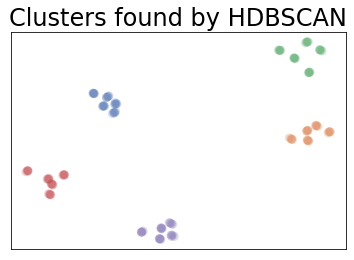

In [15]:
MAF = .05
size = len(corpus_filenames)
%time plot_clusters(UMAP().fit_transform(Xhash[:, (MAF*size <Xhash.getnnz(0)) ]), hdbscan.HDBSCAN, (), {'min_cluster_size':15}) # & (Xhash.getnnz(0)< (1- MAF)*size )

/home/thiagoms/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 5 separate connected components using meta-embedding (experimental)
  n_components


CPU times: user 32.8 s, sys: 3.89 s, total: 36.7 s
Wall time: 36.3 s


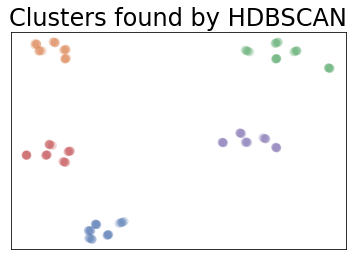

In [26]:
%time plot_clusters(UMAP().fit_transform(Xhash), hdbscan.HDBSCAN, (), {'min_cluster_size':15})

/home/thiagoms/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 5 separate connected components using meta-embedding (experimental)
  n_components


CPU times: user 44 s, sys: 4.28 s, total: 48.3 s
Wall time: 48 s


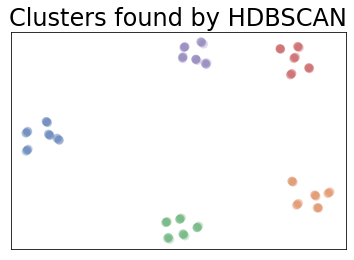

In [27]:
%time plot_clusters(UMAP().fit_transform(TfidfTransformer().fit_transform(Xhash)), hdbscan.HDBSCAN, (), {'min_cluster_size':5})

In [ ]:
#import sys
#from distutils.core import setup

In [ ]:
#from Cython.Build import cythonize

#setup(
#    ext_modules = cythonize("functions2.pyx", compiler_directives={'language_level' : sys.version_info[0]})
#)

# working on servers

In [ ]:
from dask import delayed

%load_ext cython

# Create a toy Cython function and put it into a module named remoteCython
%%cython -n remoteCython
def cython_sum(int a, int b):
    return a+b

# Set up a distributed cluster (minimal, just for illustration)
# I use SLURM.
from dask_jobqueue import SLURMCluster
from distributed import Client

cluster = SLURMCluster(memory="1GB",
                       processes=1,
                       cores=1,
                       walltime="00:10:00")

cluster.start_workers(1)   # Start as many workers as needed.



client = Client(cluster)



In [1]:
import vaex

In [16]:
df = vaex.read_csv_and_convert('data/000genome.txt', names = ['text'] ) #

ERROR:MainThread:vaex:error opening 'data/000genome.txt.hdf5'


KeyError: "Unable to open object (object 'data' doesn't exist)"

In [14]:
df

#,text
0,1stline
1,'TATCCGGTCCCATGTGGTCAGTGTTGCTCCCCCGGGGGATTAACTAA...
2,3rdline
3,4thline
4,1stline
...,...
"79,995",4thline
"79,996",1stline
"79,997",'GGAGAACTAGTTGAAAGGAGGCATATGTATCAGTAATCCATGTAGTA...
"79,998",3rdline


In [32]:
 # This runs init_pyx() on any Worker at init

In [29]:
a = []